In [1]:
#import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [2]:
# set graph styles
sns.set(font_scale = 1.3, style = 'dark')
plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
# read train dataset
df = pd.read_csv("./Dataset/drugsComTrain_raw.csv")
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
# read test dataset
df_test = pd.read_csv("./Dataset/drugsComTest_raw.csv")
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


## Data Preprocessing

In [5]:
# null values
df.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [6]:
#drop null values as they are less than 1% of the entire dataset and can not be derived
df.dropna(inplace=True)

#check for null again
df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [7]:
# remove unwanted tags
df['condition'] = df['condition'].str.replace(r'<[^<>]*>', ' ', regex=True)
#df['review'] = df['review'].str.replace(r'I[^&#]*;', "I'", regex=True)
#df.tail()

## Data Exploitation

In [8]:
# dataset statisitcs
rows, columns = df.shape

print(f"The dataset contains {rows} rows and {columns} columns")

The dataset contains 160398 rows and 7 columns


In [9]:
# cast date column to date data type
df['date'] = pd.to_datetime(df['date'])

In [10]:
# statistics of numeric values in the dataset
df.describe()

,uniqueID,rating,usefulCount
count,160398.000000,160398.000000,160398.000000
mean,115957.147309,6.995923,28.097613
std,67015.899492,3.272303,36.457876
min,2.000000,1.000000,0.000000
25%,58065.250000,5.000000,6.000000
50%,115845.500000,8.000000,16.000000
75%,173826.750000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [11]:
# dataset description
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     160398 non-null  int64         
 1   drugName     160398 non-null  object        
 2   condition    160398 non-null  object        
 3   review       160398 non-null  object        
 4   rating       160398 non-null  int64         
 5   date         160398 non-null  datetime64[ns]
 6   usefulCount  160398 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 9.8+ MB


In [12]:
# unique number of drugs reviewed
drugsCount = len(pd.unique(df['drugName']))
print(f"The dataset contains {drugsCount} unique drugs")

The dataset contains 3431 unique drugs


In [13]:
# unique number of days for reviews
reviewDateCount = len(pd.unique(df['date']))
print(f"The dataset contains {reviewDateCount} unique rview date, ranging from {min(df['date'])} to {max(df['date'])}")

The dataset contains 3579 unique rview date, ranging from 2008-02-24 00:00:00 to 2017-12-12 00:00:00


In [14]:
# function to return the aggregate of a data frame
def df_group(df, group_cols, agg_col, aggfunc = 'count'):
    result = df.groupby(group_cols).agg(
        aggregate =pd.NamedAgg(column=agg_col, aggfunc= aggfunc)
    )

    return result

In [15]:
# Drugs by the number of reviews they have
df_drugs = df_group(df,['drugName'], 'drugName')
df_drugs.head()

,aggregate
drugName,
A + D Cracked Skin Relief,1
A / B Otic,1
Abacavir / dolutegravir / lamivudine,52
Abacavir / lamivudine / zidovudine,1
Abatacept,19


In [16]:
df_drugs.tail()

,aggregate
drugName,
Zyvox,17
ZzzQuil,2
depo-subQ provera 104,1
ella,51
femhrt,3


In [17]:
# top 5 drugs by review count
top_5_drugs = df_drugs.nlargest(5, 'aggregate')
top_5_drugs.head()

,aggregate
drugName,
Levonorgestrel,3631
Etonogestrel,3321
Ethinyl estradiol / norethindrone,2750
Nexplanon,2156
Ethinyl estradiol / norgestimate,2033


In [18]:
# bottom 5 drugs by review count
bottom_5_drugs = df_drugs.nsmallest(5, 'aggregate')
bottom_5_drugs.head()

,aggregate
drugName,
A + D Cracked Skin Relief,1
A / B Otic,1
Abacavir / lamivudine / zidovudine,1
Absorbine Jr.,1
Acarbose,1


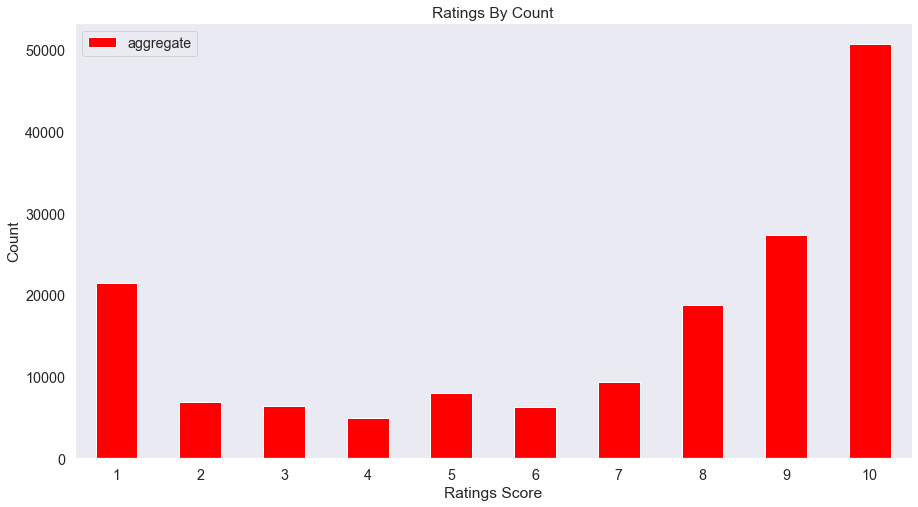

In [19]:
# plot review ratings count across the 10 points rating
df_ratings = df_group(df,['rating'], 'rating')
df_ratings.plot(kind=  'bar',  color = 'red')

plt.xlabel("Ratings Score")
plt.ylabel("Count")
plt.title("Ratings By Count")
plt.xticks(rotation = 0)
plt.show()

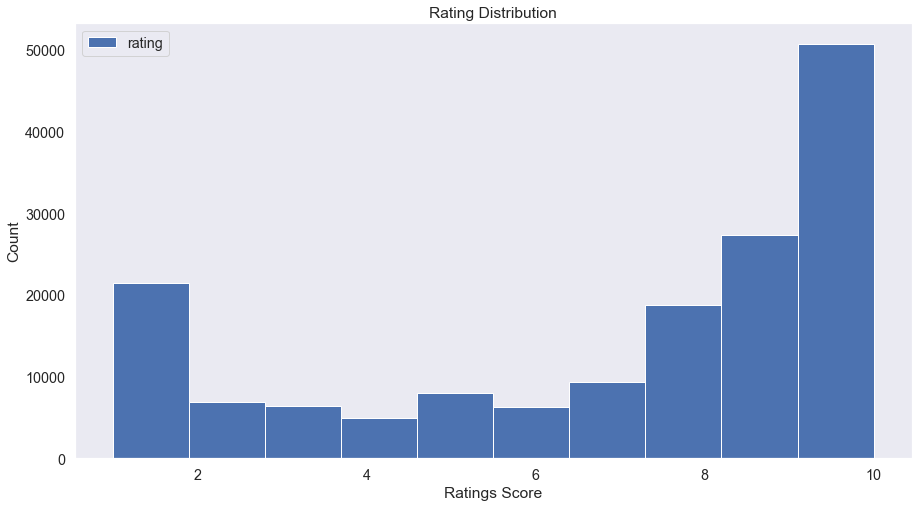

In [20]:
# plot review ratings distribution across the 10 points rating
df.plot(kind = 'hist', y= 'rating')

plt.xlabel("Ratings Score")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

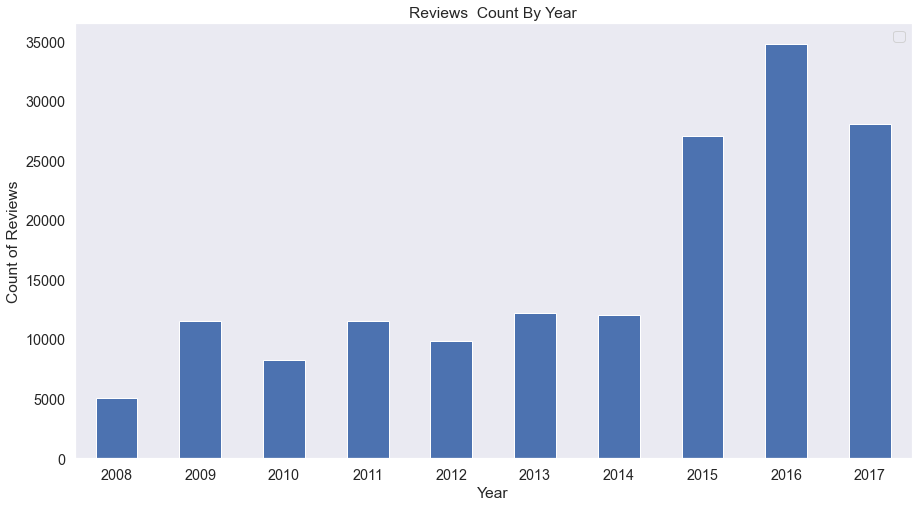

In [21]:
# Review By Year
df['year'] = df['date'].dt.year
df_year = df_group(df, ['year'], 'year')

df_year.plot.bar()

plt.title('Reviews  Count By Year')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.legend("")
plt.xticks(rotation = 0)
plt.show()

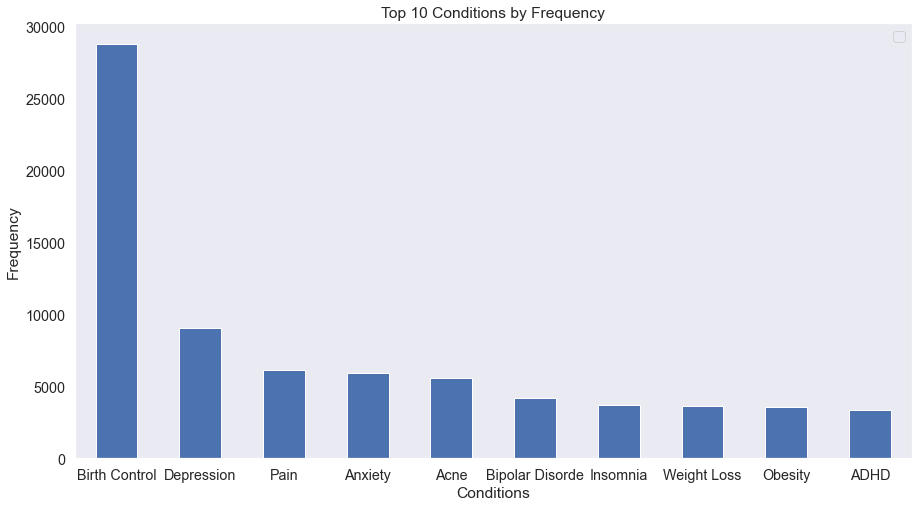

In [22]:
# Conditions exploration
conditions_df = df_group(df, ['condition'], 'condition')
conditions_df.nlargest(10, 'aggregate').plot.bar()

plt.title('Top 10 Conditions by Frequency')
plt.xlabel('Conditions')
plt.ylabel('Frequency')
plt.legend("")
plt.xticks(rotation = 0)
plt.show()

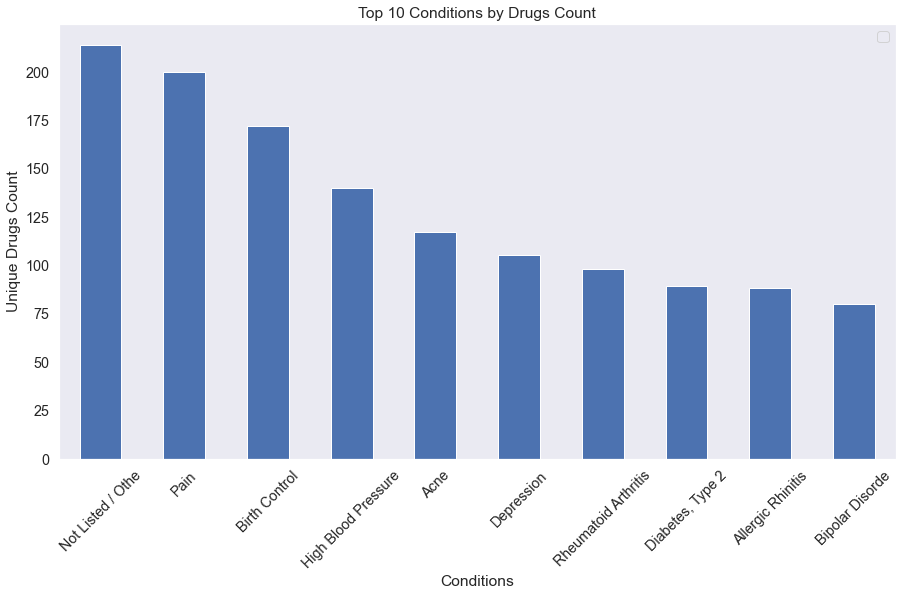

In [23]:
# Count of Drugs by Conditions exploration
drug_count_df = df_group(df, ['condition'], 'drugName', 'nunique')
drug_count_df.nlargest(10, 'aggregate').plot.bar()

plt.title('Top 10 Conditions by Drugs Count')
plt.xlabel('Conditions')
plt.ylabel('Unique Drugs Count')
plt.legend("")
plt.xticks(rotation = 45)
plt.show()

## Sentiment Analysis

In [24]:
# Calculate the sentiment of the reviews
def calculate_sentiment(review):
    result = TextBlob(review)
    score = result.polarity

    return score

def sentiment_label(score):
    if score < 0:
        return 'negative'
    elif score > 0:
        return 'positive'
    else:
        return 'neutral'

In [25]:
# Sentiment Score for Review
df['sentiment_score']  = df['review'].apply(calculate_sentiment)


In [26]:
# Sentiment label (positive, negative or neutral)
df['sentiment'] = df['sentiment_score'].apply(sentiment_label)

In [27]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,year,sentiment_score,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,0.000000,neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,0.168333,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,0.067210,positive
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,0.179545,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,0.194444,positive


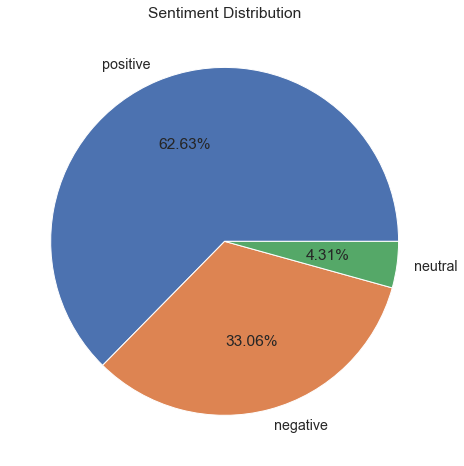

In [28]:
# Sentiment Distibution
def autopct_fn(values):
    def format_show(pct):
        return '{:.2f}%'.format(pct)
    return format_show

sentiment_count = df['sentiment'].value_counts()
plt.title("Sentiment Distribution")
plt.pie(sentiment_count,labels = sentiment_count.index, autopct=autopct_fn(sentiment_count))

plt.show()

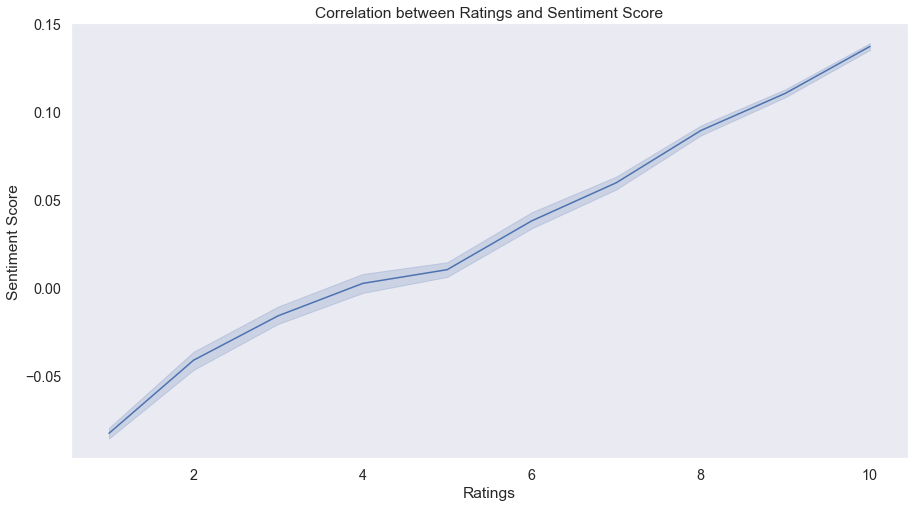

In [29]:
# Correlation between the sentiment and the ratings
sns.lineplot(data=df,x='rating',y='sentiment_score')
plt.xlabel('Ratings')
plt.ylabel('Sentiment Score')
plt.title("Correlation between Ratings and Sentiment Score")

plt.show()

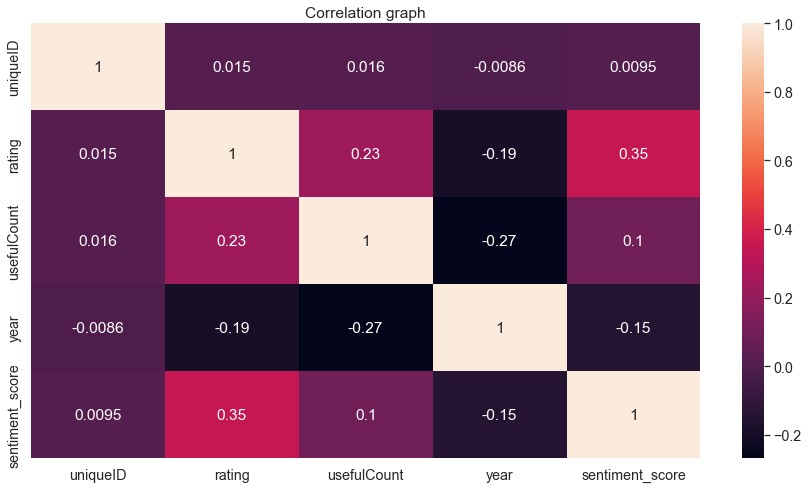

In [30]:
# correlation of the variables
sns.heatmap(df.corr(), annot=True)
plt.title("Correlation graph")
plt.show()

## Model Development

In [31]:
# split data to X and y
X = df.drop(['uniqueID','review','rating','date','sentiment'],axis=1)
y = df['sentiment'].values

X.head()

,drugName,condition,usefulCount,year,sentiment_score
0,Valsartan,Left Ventricular Dysfunction,27,2012,0.000000
1,Guanfacine,ADHD,192,2010,0.168333
2,Lybrel,Birth Control,17,2009,0.067210
3,Ortho Evra,Birth Control,10,2015,0.179545
4,Buprenorphine / naloxone,Opiate Dependence,37,2016,0.194444


In [32]:
# encoding categorical X columns
encod = OrdinalEncoder()
X[['drugName', 'condition']] = encod.fit_transform(X[['drugName', 'condition']])
X.head()

,drugName,condition,usefulCount,year,sentiment_score
0,3198.0,466.0,27,2012,0.000000
1,1428.0,73.0,192,2010,0.168333
2,1851.0,165.0,17,2009,0.067210
3,2280.0,165.0,10,2015,0.179545
4,515.0,574.0,37,2016,0.194444


In [33]:
# standardizing X values
sc = StandardScaler()
X[['drugName', 'condition', 'usefulCount', 'year']] = sc.fit_transform(X[['drugName', 'condition', 'usefulCount', 'year']])
X.head()

,drugName,condition,usefulCount,year,sentiment_score
0,1.585622,0.456979,-0.030106,-0.722385,0.000000
1,-0.293619,-1.207277,4.495679,-1.460688,0.168333
2,0.155488,-0.817680,-0.304396,-1.829839,0.067210
3,0.610965,-0.817680,-0.496399,0.385068,0.179545
4,-1.262967,0.914332,0.244184,0.754219,0.194444


In [34]:
# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
a = df[df['drugName'] == 'A / B Otic']['condition'].unique().tolist()
b = a if len(a) < 2 else a.insert(len(a) - 1, 'and')
",".join(b)

'Otitis Media'

## Model Development

In [57]:
# get alternative drugs reccomendation
def get_reccommendation(model, matrix_df, drug_name, neighbor):
    conditions = df[df['drugName'] == drug_name]['condition'].unique().tolist()
    
    # check to see if to add and to the joint list
#     if len(conditions) < 2:
#         pass
#     else:
#         conditions.insert(len(conditions) - 1, 'and')
    
    distances, indices = model.kneighbors(matrix_df.loc[drug_name].values.reshape(1,-1), n_neighbors = neighbor)
    for i in range(0, len(distances.flatten())):
        if i == 0 :
            print(f'Alternative Reccommendations for {matrix_df.index[indices.flatten()[i]]} that is a medicine for conditions {conditions} are:\n')
        else:
            con = df[df['drugName'] == matrix_df.index[indices.flatten()[i]]]['condition'].unique().tolist()
            #print(f'{i}: {matrix_df.index[indices.flatten()[i]]} used for conditions {con}, has a distance of {distances.flatten()[i]}:')
            print(f'{i}: {matrix_df.index[indices.flatten()[i]]} used for conditions {con} with distance {distances.flatten()[i]}.')

In [37]:
drug_matrix = df.pivot_table(index = 'drugName', columns=  'condition', values='rating').fillna(0)
drug_matrix.head()

condition,0 users found this comment helpful.,1 users found this comment helpful.,10 users found this comment helpful.,11 users found this comment helpful.,110 users found this comment helpful.,12 users found this comment helpful.,121 users found this comment helpful.,123 users found this comment helpful.,13 users found this comment helpful.,14 users found this comment helpful.,...,moterol),mulation) (phenylephrine),t Care,t Pac with Cyclobenzaprine (cyclobenzaprine),tic (mycophenolic acid),unctional Gastric Disorde,ungal Infection Prophylaxis,ungal Pneumonia,von Willebrand's Disease,zen Shoulde
drugName,,,,,,,,,,,,,,,,,,,,,
A + D Cracked Skin Relief,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A / B Otic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abacavir / dolutegravir / lamivudine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abacavir / lamivudine / zidovudine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abatacept,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Base Classifer model

In [38]:
# # create base reccomendation model
base  = NearestNeighbors()
drug_sparse = csr_matrix(drug_matrix.values)
base.fit(drug_sparse)


NearestNeighbors()

In [39]:
# check optimal neighbor
neighbor = base.n_neighbors
neighbor

5

In [47]:
# get params of base model
base.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

In [58]:
# Test base model
get_reccommendation(base, drug_matrix, 'Valsartan', neighbor)

Alternative Reccommendations for Valsartan that is a medicine for conditions ['Left Ventricular Dysfunction', 'High Blood Pressure'] are:

1: Benazepril used for conditions ['High Blood Pressure', 'Left Ventricular Dysfunction'] with distance 1.6919870331642264.
2: Azilsartan medoxomil used for conditions ['High Blood Pressure'] with distance 9.500027185694028.
3: Ziac used for conditions ['High Blood Pressure'] with distance 9.500278377826534.
4: Procardia XL used for conditions ['High Blood Pressure'] with distance 9.500592026403298.


### Validate model

### Main Reccommendation Engine

In [41]:
# pivot table for use
drug_matrix_m = df.pivot_table(index = 'drugName', columns=  'condition', values='rating').fillna(0)
drug_matrix_m.head()

condition,0 users found this comment helpful.,1 users found this comment helpful.,10 users found this comment helpful.,11 users found this comment helpful.,110 users found this comment helpful.,12 users found this comment helpful.,121 users found this comment helpful.,123 users found this comment helpful.,13 users found this comment helpful.,14 users found this comment helpful.,...,moterol),mulation) (phenylephrine),t Care,t Pac with Cyclobenzaprine (cyclobenzaprine),tic (mycophenolic acid),unctional Gastric Disorde,ungal Infection Prophylaxis,ungal Pneumonia,von Willebrand's Disease,zen Shoulde
drugName,,,,,,,,,,,,,,,,,,,,,
A + D Cracked Skin Relief,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A / B Otic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abacavir / dolutegravir / lamivudine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abacavir / lamivudine / zidovudine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abatacept,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# # create main reccomendation model
knn  = NearestNeighbors(metric = 'cosine', algorithm = 'brute', leaf_size= 90, n_neighbors = 4)
drug_sparse_m = csr_matrix(drug_matrix.values)
knn.fit(drug_sparse_m)


NearestNeighbors(algorithm='brute', leaf_size=90, metric='cosine',
                 n_neighbors=4)

In [45]:
# check optimal neighbor
neighbor_m = knn.n_neighbors
neighbor_m

4

In [46]:
# get model params
knn.get_params()

{'algorithm': 'brute',
 'leaf_size': 90,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 4,
 'p': 2,
 'radius': 1.0}

In [59]:
# Test main model
get_reccommendation(knn, drug_matrix, "Valsartan", neighbor_m)

Alternative Reccommendations for Valsartan that is a medicine for conditions ['Left Ventricular Dysfunction', 'High Blood Pressure'] are:

1: Benazepril used for conditions ['High Blood Pressure', 'Left Ventricular Dysfunction'] with distance 0.009847714466739488.
2: Diovan used for conditions ['High Blood Pressure', 'Left Ventricular Dysfunction', '33  users found this comment helpful.'] with distance 0.25917576181463564.
3: Enalapril used for conditions ['High Blood Pressure', 'Left Ventricular Dysfunction', 'Hypertensive Emergency', 'Diabetic Kidney Disease'] with distance 0.31746278977074605.


### Conclusion
The base model uses a leaf_size of 30 and a K of 5 which is by default while the main uses a K value of 4 and a leaf_size of 90. This allows the main model to be able to disallow overfitting and be able to reccommend drugs that are actually able to fulfil the different conditions the alternative drugs can while the base model is more streamlined to only on of the conditions